# Data Preprocessing

This notebook clarifies the nature of our data and the series of preprocessing steps implemented. We've adopted the Medallion Architecture as our guiding principle for data refinement. Within this structure, every data source progresses through three distinct layers: Bronze, Silver, and Gold. Each layer serves its own unique purpose in the pipeline.

## Overview of the Layers:

### 1. **Bronze Layer (Raw Data)**
- **Nature**: This is the landing area for our raw data, ingested directly from the source without any alterations.
- **Purpose**: To store an immutable, 1:1 replica of the source data. It serves as the foundational bedrock upon which further layers are built.

### 2. **Silver Layer (Cleaned Data)**
- **Nature**: Data in this layer has been cleaned, enriched, and is stored in a format suitable for analysis. Any inconsistencies, missing values, or anomalies from the Bronze layer have been addressed here.
- **Purpose**: To have a reliable, single version of the truth which is suitable for analysis but without any specific business logic applied. This is the primary layer for data scientists and analysts to query against.

### 3. **Gold Layer (Business-Ready Data)**
- **Nature**: This layer houses data that has been aggregated, enriched, and optimized for specific business use-cases. It is derived from the Silver layer.
- **Purpose**: To provide business-ready datasets for driving insights, reports, visualizations, and machine learning models. This layer is tailored to end-users and specific analytical objectives.


In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import normaltest
from unidecode import unidecode

# supress warnings
import warnings
warnings.filterwarnings('ignore')


### Player skill dataset

In [29]:
# Bronze Layer
player_data = pd.read_csv('../data/playersV2.csv.gz')
pd.set_option('display.max_columns', None)
player_data.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM, ST",94,94,87000000.0,575000.0,31,1985-02-05,185,80,243.0,Real Madrid CF,Spain Primera Division,1.0,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LS,7.0,Right,4,5,5,High/Low,Unique,Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",92.0,92.0,81.0,91.0,33.0,80.0,84,93,87,82,88,93,81,77,72,92,91,92,90,96,63,94,95,92,80,92,63,29,94,85,85,86,22,31,23,7,11,15,14,11,NaN,91+3,91+3,91+3,91+3,91+3,91+3,91+3,91+3,89+4,89+4,89+4,89+4,81+4,81+4,81+4,89+4,65+4,61+4,61+4,61+4,65+4,61+4,53+4,53+4,53+4,61+4,20+4,https://cdn.sofifa.net/players/020/801/17_120.png,https://cdn.sofifa.net/teams/243/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,2017
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,RW,93,93,89000000.0,575000.0,29,1987-06-24,170,72,241.0,FC Barcelona,Spain Primera Division,1.0,RW,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Medium,Unique,Yes,NaN,"#Dribbler, #FK Specialist, #Acrobat, #Clinical...","Finesse Shot, Long Shot Taker (AI), Speed Drib...",89.0,90.0,86.0,96.0,26.0,61.0,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,83,68,74,59,88,48,22,93,90,74,94,13,28,26,6,11,15,14,8,NaN,88+4,88+4,88+4,91+2,92+1,92+1,92+1,91+2,92+1,92+1,92+1,90+3,84+4,84+4,84+4,90+3,62+4,59+4,59+4,59+4,62+4,57+4,45+4,45+4,45+4,57+4,19+4,https://cdn.sofifa.net/players/158/023/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,2017
2,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,92,92,69500000.0,225000.0,30,1986-03-27,193,92,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2021.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Normal (185+),Yes,NaN,NaN,"GK Long Throw, 1-on-1 Rush, Rushes Out Of Goal...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,11,89,90,95,91,89,60.0,36+4,36+4,36+4,40+3,41+3,41+3,41+3,40+3,47+4,47+4,47+4,44+4,48+4,48+4,48+4,44+4,36+4,41+4,41+4,41+4,36+4,34+4,33+4,33+4,33+4,34+4,89+3,https://cdn.sofifa.net/players/167/495/17_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2017
3,176580,https://sof

In [30]:
# Display summary statistics for the dataset
summary_statistics = player_data.describe(include='all').transpose()
# Display the first few rows of the summary statistics
summary_statistics[2:18]


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
short_name,91062,33295,J. Rodríguez,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long_name,91062,35694,Joe Riley,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player_positions,91062,1462,CB,11409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overall,91062.0,NaN,NaN,NaN,66.069381,7.024394,45.0,62.0,66.0,71.0,94.0
potential,91062.0,NaN,NaN,NaN,71.184347,6.141655,45.0,67.0,71.0,75.0,95.0
value_eur,89783.0,NaN,NaN,NaN,2446243.208625,5919886.487949,2000.0,350000.0,750000.0,1900000.0,185500000.0
wage_eur,89903.0,NaN,NaN,NaN,10303.792977,21705.03642,500.0,2000.0,4000.0,10000.0,575000.0
age,91062.0,NaN,NaN,NaN,25.189201,4.650374,16.0,21.0,25.0,28.0,53.0
dob,91062,7799,1992-02-29,736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_cm,91062.0,NaN,NaN,NaN,181.223858,6.735524,154.0,176.0,181.0,186.0,207.0


In [31]:
# Calculate the percentage of missing values for each column
missing_values = player_data.isnull().mean() * 100

# Filter out columns with no missing values
missing_values = missing_values[missing_values > 0]

# Sort the columns based on the percentage of missing values in descending order
missing_values = missing_values.sort_values(ascending=False)

# Convert the Series to a DataFrame for better visualization
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Column Name', 'Percentage of Missing Values']

# Format the percentage values for better readability
missing_values_df['Percentage of Missing Values'] = missing_values_df['Percentage of Missing Values'].apply(lambda x: f"{x:.2f}%")

# Display the DataFrame with missing values and their corresponding percentage
missing_values_df


,Column Name,Percentage of Missing Values
0,club_loaned_from,94.25%
1,nation_jersey_number,93.86%
2,nation_position,93.86%
3,nation_team_id,93.86%
4,nation_logo_url,93.86%
5,player_tags,91.94%
6,goalkeeping_speed,88.82%
7,player_traits,55.75%
8,release_clause_eur,24.85%
9,pace,11.18%


# Feature correlation

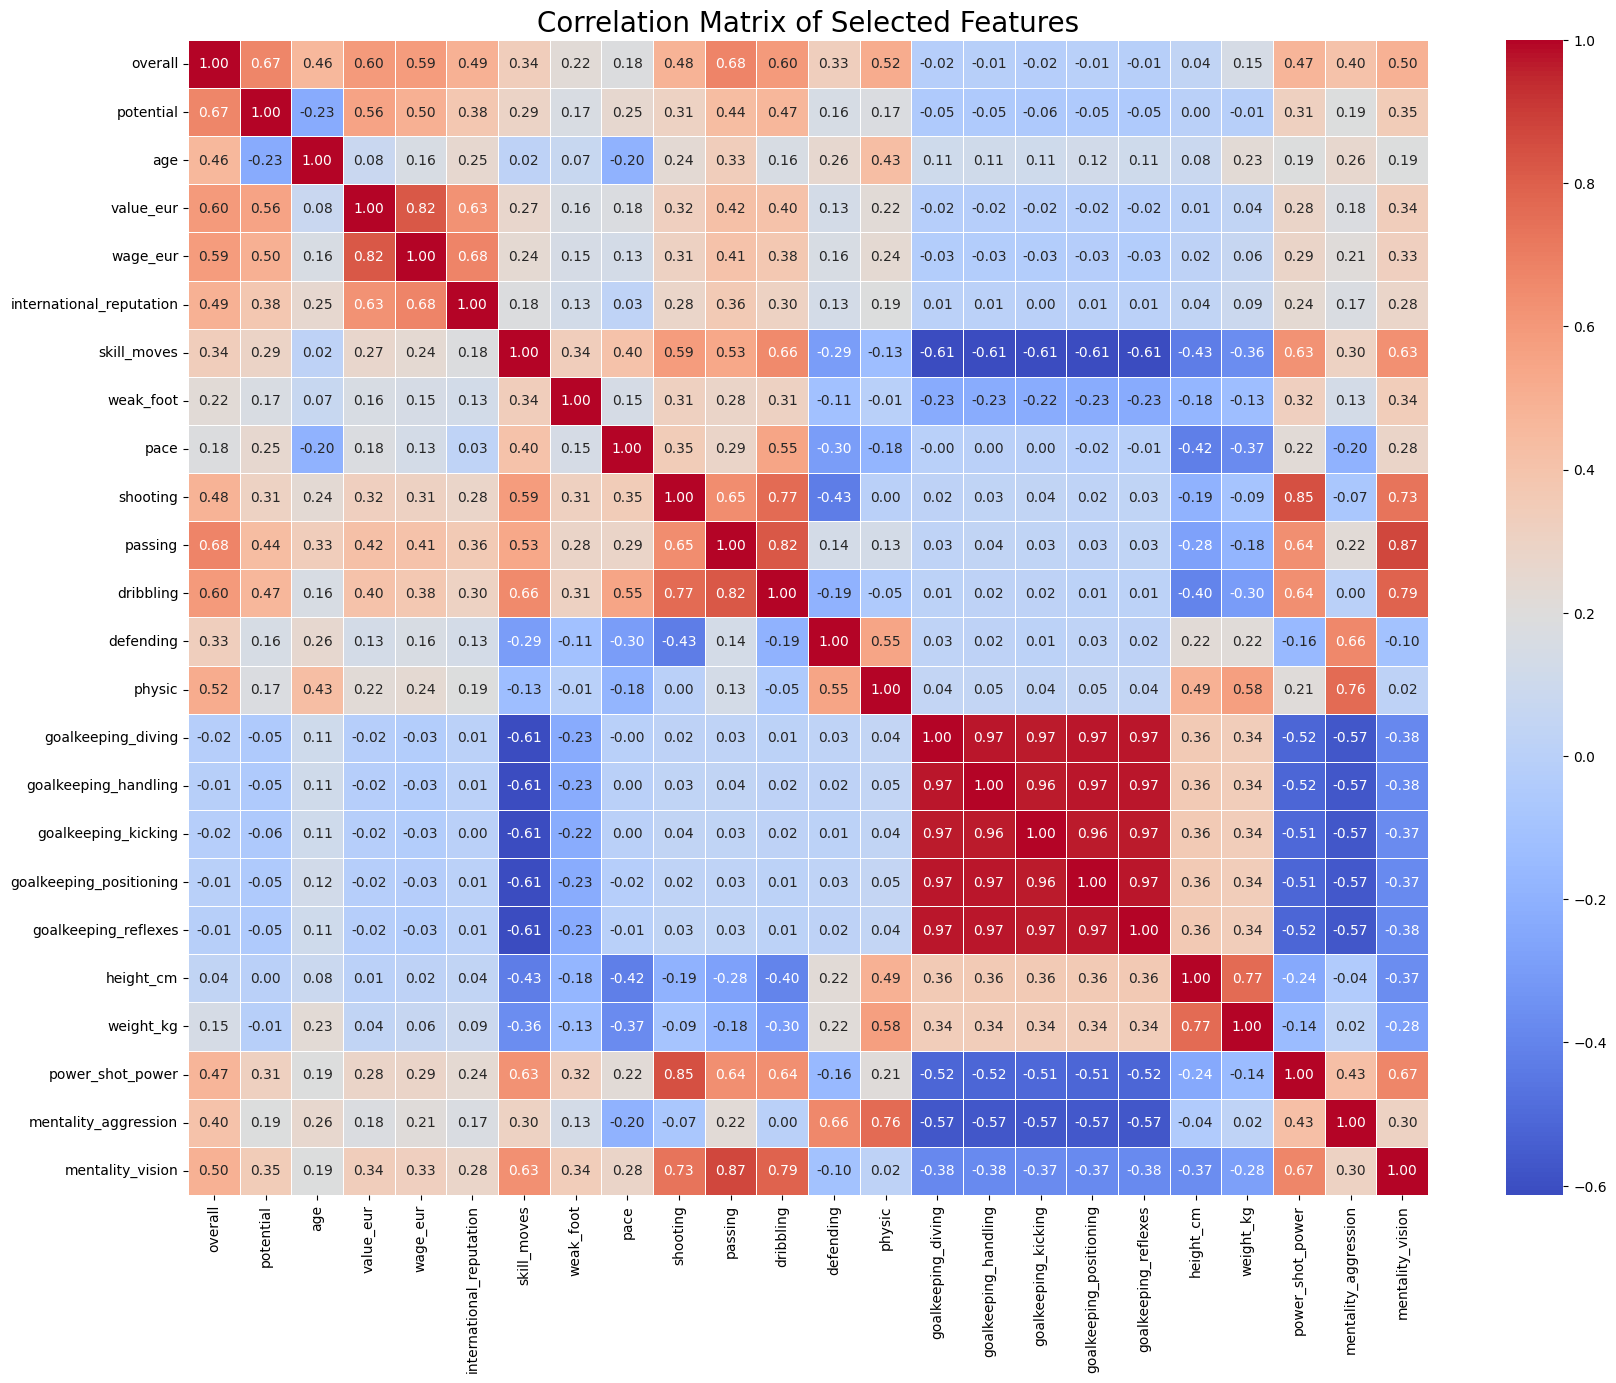

In [32]:
# Select relevant features for correlation analysis
selected_features = [
    'overall', 'potential', 'age', 'value_eur', 'wage_eur',
    'international_reputation', 'skill_moves', 'weak_foot',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes',
    'height_cm', 'weight_kg', 'power_shot_power', 'mentality_aggression', 'mentality_vision'
]

# Calculate the correlation matrix for the selected features
correlation_matrix = player_data[selected_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

# Set the title of the heatmap
plt.title('Correlation Matrix of Selected Features', fontsize=20)

# Show the heatmap
plt.show()


Overall and Potential Ratings: overall and potential have a strong positive correlation (0.66), indicating that players with higher overall ratings tend to have higher potential ratings.

Age and Ratings: age has a negative correlation with potential (-0.26) and a positive correlation with overall (0.46), suggesting that younger players tend to have higher potential, while older players tend to have higher overall ratings.

Value and Wage: value_eur and wage_eur are strongly correlated (0.86), indicating that players with higher value tend to have higher wages.

Skill Ratings: Features like shooting, passing, dribbling, and physic are positively correlated with overall, indicating that higher skill ratings contribute to a higher overall rating.

Goalkeeping Attributes: Goalkeeping attributes are negatively correlated with outfield player attributes, suggesting a distinction between goalkeepers and outfield players.

Physical Attributes: height_cm and weight_kg are positively correlated (0.76), indicating that taller players tend to be heavier.

International Reputation: international_reputation has a strong positive correlation with value_eur (0.65) and wage_eur (0.67), indicating that players with higher international reputation tend to have higher value and wages.

# Wage Disparity Analysis

In [33]:
# Calculate the average wage for players from each nationality
average_wage_by_nationality = player_data.groupby('nationality_name')['wage_eur'].mean().reset_index()
# Sort the DataFrame based on average wage in descending order
average_wage_by_nationality = average_wage_by_nationality.sort_values(by='wage_eur', ascending=False)
# Display the top 10 nationalities with the highest average player wages
average_wage_by_nationality.head(10)


,nationality_name,wage_eur
46,Dominican Republic,35133.333333
48,Egypt,28278.481013
7,Armenia,24115.116279
59,Gabon,22888.513514
39,Croatia,20065.466448
2,Algeria,20028.624535
160,Syria,18428.000000
15,Belgium,17608.161004
21,Brazil,16956.701754
153,Spain,16721.552222


In [34]:
# Calculate the average wage for players in each league
average_wage_by_league = player_data.groupby('league_name')['wage_eur'].mean().reset_index()
# Sort the DataFrame based on average wage in descending order
average_wage_by_league = average_wage_by_league.sort_values(by='wage_eur', ascending=False)
# Display the top 10 leagues with the highest average player wages
average_wage_by_league.head(10)

,league_name,wage_eur
16,English Premier League,53796.503497
43,Spain Primera Division,34096.291477
25,Italian Serie A,31450.486414
20,German 1. Bundesliga,27374.360380
18,French Ligue 1,20168.354643
39,Russian Premier League,19245.514636
47,Turkish Süper Lig,14692.089094
13,English League Championship,13679.846369
4,Campeonato Brasileiro Série A,13529.878049
30,Mexican Liga MX,12685.955277


In [35]:
# Calculate the average wage for players in each club
average_wage_by_club = player_data.groupby('club_name')['wage_eur'].mean().reset_index()
# Sort the DataFrame based on average wage in descending order
average_wage_by_club = average_wage_by_club.sort_values(by='wage_eur', ascending=False)
# Display the top 10 clubs with the highest average player wages
average_wage_by_club.head(10)


,club_name,wage_eur
661,Real Madrid CF,160082.802548
317,FC Barcelona,158558.441558
546,Manchester City,109160.606061
484,Juventus,108139.860140
320,FC Bayern München,100604.651163
547,Manchester United,98237.804878
178,Chelsea,95278.787879
530,Liverpool,85172.121212
70,Arsenal,77309.090909
615,Paris Saint-Germain,72451.307190


In [36]:
# Calculate a disparity score by dividing the average wage by the average overall rating for each nationality
average_rating_by_nationality = player_data.groupby('nationality_name')['overall'].mean().reset_index()
nationality_comparison = pd.merge(average_wage_by_nationality, average_rating_by_nationality, on='nationality_name')
nationality_comparison['disparity_score'] = nationality_comparison['wage_eur'] / nationality_comparison['overall']

# Sort the DataFrame based on disparity score in ascending order
nationality_disparity = nationality_comparison.sort_values(by='disparity_score', ascending=True)

# Display the top 10 nationalities with the lowest disparity scores (high ratings but lower wages)
nationality_disparity


,nationality_name,wage_eur,overall,disparity_score
178,Sri Lanka,500.000000,60.000000,8.333333
180,India,500.000000,59.295652,8.432321
177,Malawi,575.000000,66.000000,8.712121
179,San Marino,500.000000,54.000000,9.259259
176,Nicaragua,666.666667,61.333333,10.869565
...,...,...,...,...
4,Croatia,20065.466448,69.232406,289.827664
3,Gabon,22888.513514,70.337838,325.408261
2,Armenia,24115.116279,68.767442,350.676361
1,Egypt,28278.481013,69.993548,404.015537


In [37]:
# Calculate the count of players from each nationality
player_count_by_nationality = player_data.groupby('nationality_name')['sofifa_id'].count().reset_index()
player_count_by_nationality = player_count_by_nationality.rename(columns={'sofifa_id': 'player_count'})
# Merge the player count with the nationality disparity DataFrame
nationality_disparity = pd.merge(nationality_disparity, player_count_by_nationality, on='nationality_name')
# Display the updated DataFrame with the player count included for the top 10 nationalities with the lowest disparity scores
nationality_disparity[['nationality_name', 'disparity_score', 'overall', 'wage_eur', 'player_count']]


,nationality_name,disparity_score,overall,wage_eur,player_count
0,Sri Lanka,8.333333,60.000000,500.000000,1
1,India,8.432321,59.295652,500.000000,115
2,Malawi,8.712121,66.000000,575.000000,2
3,San Marino,9.259259,54.000000,500.000000,1
4,Nicaragua,10.869565,61.333333,666.666667,3
...,...,...,...,...,...
176,Croatia,289.827664,69.232406,20065.466448,611
177,Gabon,325.408261,70.337838,22888.513514,74
178,Armenia,350.676361,68.767442,24115.116279,43
179,Egypt,404.015537,69.993548,28278.481013,155


In [38]:
# show nationality_name = egypt
nationality_disparity[nationality_disparity['nationality_name'] == 'Egypt']

,nationality_name,wage_eur,overall,disparity_score,player_count
179,Egypt,28278.481013,69.993548,404.015537,155


In [39]:
from scipy.stats import ttest_ind

# List to store the results of the t-tests
t_test_results = []

# Overall population of player wages (excluding players with zero wages)
overall_wages_population = player_data[player_data['wage_eur'] > 0]['wage_eur']

# Calculate the number of unique players for each nationality
unique_player_count = player_data.groupby('nationality_name')['short_name'].nunique().reset_index()
unique_player_count.rename(columns={'short_name': 'unique_player_count'}, inplace=True)

# Perform t-test for each of the top 10 nationalities with the lowest disparity scores
for index, row in nationality_disparity.iterrows():
    # Wages of players from the specific nationality (excluding players with zero wages)
    nationality_wages = player_data[(player_data['nationality_name'] == row['nationality_name']) & (player_data['wage_eur'] > 0)]['wage_eur']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(nationality_wages, overall_wages_population, equal_var=False)
    
    # Append results to the list
    t_test_results.append({'nationality_name': row['nationality_name'], 't_stat': t_stat, 'p_value': p_value})

# Convert the results list to a DataFrame
t_test_results_df = pd.DataFrame(t_test_results)

# Merge the t-test results with the nationality disparity DataFrame
nationality_disparity = pd.merge(nationality_disparity, t_test_results_df, on='nationality_name', suffixes=('', '_y'))

# Merge the unique_player_count with the nationality_disparity DataFrame
nationality_disparity = pd.merge(nationality_disparity, unique_player_count, on='nationality_name')

# Display the updated DataFrame with t-test results and unique_player_count included
nationality_disparity[['nationality_name', 'disparity_score', 'overall', 'wage_eur', 'player_count', 'unique_player_count', 't_stat', 'p_value']].head(10)


,nationality_name,disparity_score,overall,wage_eur,player_count,unique_player_count,t_stat,p_value
0,Sri Lanka,8.333333,60.000000,500.000000,1,1,NaN,NaN
1,India,8.432321,59.295652,500.000000,115,58,NaN,NaN
2,Malawi,8.712121,66.000000,575.000000,2,1,-93.334100,2.011331e-07
3,San Marino,9.259259,54.000000,500.000000,1,1,NaN,NaN
4,Nicaragua,10.869565,61.333333,666.666667,3,3,-53.036200,2.525480e-05
5,Papua New Guinea,12.096774,62.000000,750.000000,2,2,-36.707316,9.649093e-03
6,Bolivia,12.836591,63.289256,812.418301,242,157,-78.413354,7.632229e-232
7,Andorra,14.516129,62.000000,900.000000,2,1,-76.174200,5.340127e-05
8,Indonesia,15.178571,56.000000,850.000000,3,1,-56.761177,1.062742e-05
9,Malaysia,17.857143,56.000000,1000.000000,1,1,NaN,NaN


In [42]:
import plotly.express as px

# Assuming nationality_disparity DataFrame already has columns 'nationality_name', 'disparity_score', and 't_stat'
# Merge with unique_player_count DataFrame to get the unique player count for each nationality
final_df = nationality_disparity

# Create an interactive scatter plot using plotly
fig = px.scatter(final_df, 
                 x='disparity_score', 
                 y='unique_player_count',
                 color='t_stat',
                 hover_data=['nationality_name'],
                 title='Scatter Plot of Unique Player Count by Nationality',
                 labels={'disparity_score': 'Disparity Score', 'unique_player_count': 'Unique Player Count'})

# Show the plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

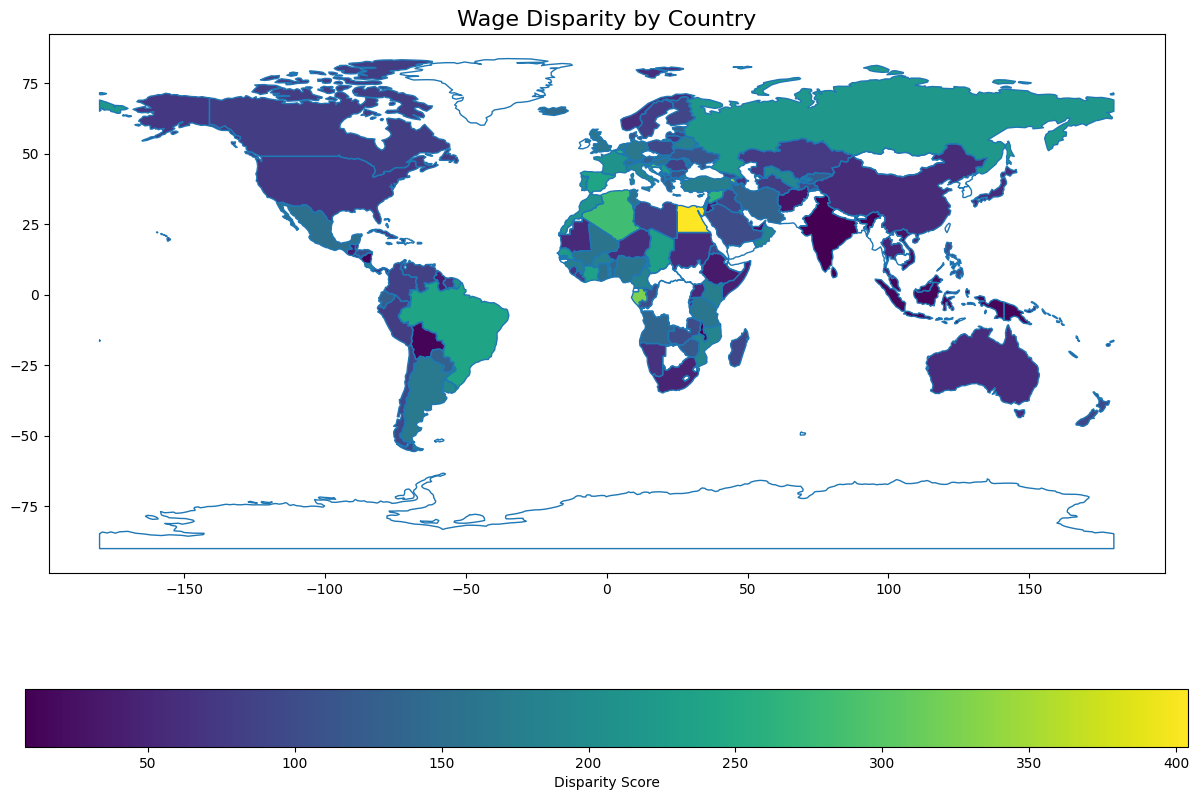

In [43]:
import geopandas as gpd

# Define a dictionary to map the country name in your dataset to the name used in the GeoPandas dataset
correction_dict = {
    'United States': 'United States of America',
    'China PR': 'China',
    'England': 'United Kingdom'
    # a few more countrie need mapped like england and china
}

# Apply corrections to the country names in dataset
nationality_disparity['nationality_name'] = nationality_disparity['nationality_name'].replace(correction_dict)
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge the world map with the nationality disparity DataFrame based on country name
merged = world.set_index('name').join(nationality_disparity.set_index('nationality_name'))
# Set up the matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# Plot the map
merged.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='disparity_score', ax=ax, legend=True,
            legend_kwds={'label': "Disparity Score", 'orientation': "horizontal"})

# Add title
plt.title('Wage Disparity by Country', fontsize=16)

# Show the plot
plt.show()


In [44]:
import plotly.express as px

# Merge the nationality_disparity DataFrame with the GeoPandas world map DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged = world.set_index('name').join(nationality_disparity.set_index('nationality_name'))
# Create an interactive choropleth map using Plotly with a different color scale for disparity score
fig = px.choropleth(
    merged,
    geojson=merged.geometry,
    locations=merged.index,
    color='disparity_score',
    hover_data=['overall', 'wage_eur', 'player_count'],
    title='Wage Disparity by Country',
    color_continuous_scale='Cividis',  # Changed color scale
)
# Update layout for larger dimensions, additional styling, and customized ocean color
fig.update_layout(
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='white',
        showocean=True,
        oceancolor='#E0E0E0',  # Customized ocean color to resemble a soccer theme
        showcountries=True,
        countrycolor='darkgrey'
    ),
    margin={"r":0,"t":40,"l":0,"b":0},
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [45]:
import plotly.express as px
egyptian_players_df = player_data[player_data['nationality_name'] == 'Egypt']

# Create an interactive scatter plot using plotly
fig = px.scatter(egyptian_players_df, x='overall', y='value_eur',
                 hover_data=['short_name'], # Display player name on hover
                 title='Interactive Scatter plot of Player Values and Ratings for Egyptian Players',
                 labels={'overall': 'Player Rating (Overall)', 'value_eur': 'Player Value (EUR)'},
                 )

# Show the interactive plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Data enrichment

In [46]:
# Check the unique values in the 'player_positions' column of the players_df dataset
unique_player_positions = player_data['player_positions'].unique()

# Display the unique player positions
len(unique_player_positions)


1462

In [47]:
player_data

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM, ST",94,94,87000000.0,575000.0,31,1985-02-05,185,80,243.0,Real Madrid CF,Spain Primera Division,1.0,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LS,7.0,Right,4,5,5,High/Low,Unique,Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",92.0,92.0,81.0,91.0,33.0,80.0,84,93,87,82,88,93,81,77,72,92,91,92,90,96,63,94,95,92,80,92,63,29,94,85,85,86,22,31,23,7,11,15,14,11,NaN,91+3,91+3,91+3,91+3,91+3,91+3,91+3,91+3,89+4,89+4,89+4,89+4,81+4,81+4,81+4,89+4,65+4,61+4,61+4,61+4,65+4,61+4,53+4,53+4,53+4,61+4,20+4,https://cdn.sofifa.net/players/020/801/17_120.png,https://cdn.sofifa.net/teams/243/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,2017
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,RW,93,93,89000000.0,575000.0,29,1987-06-24,170,72,241.0,FC Barcelona,Spain Primera Division,1.0,RW,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Medium,Unique,Yes,NaN,"#Dribbler, #FK Specialist, #Acrobat, #Clinical...","Finesse Shot, Long Shot Taker (AI), Speed Drib...",89.0,90.0,86.0,96.0,26.0,61.0,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,83,68,74,59,88,48,22,93,90,74,94,13,28,26,6,11,15,14,8,NaN,88+4,88+4,88+4,91+2,92+1,92+1,92+1,91+2,92+1,92+1,92+1,90+3,84+4,84+4,84+4,90+3,62+4,59+4,59+4,59+4,62+4,57+4,45+4,45+4,45+4,57+4,19+4,https://cdn.sofifa.net/players/158/023/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,2017
2,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,92,92,69500000.0,225000.0,30,1986-03-27,193,92,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2021.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Normal (185+),Yes,NaN,NaN,"GK Long Throw, 1-on-1 Rush, Rushes Out Of Goal...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,11,89,90,95,91,89,60.0,36+4,36+4,36+4,40+3,41+3,41+3,41+3,40+3,47+4,47+4,47+4,44+4,48+4,48+4,48+4,44+4,36+4,41+4,41+4,41+4,36+4,34+4,33+4,33+4,33+4,34+4,89+3,https://cdn.sofifa.net/players/167/495/17_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2017
3,176580,https://sof

In [48]:
# Define the mapping of position abbreviations to general positions
position_mapping = {
    'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward', 'LS': 'Forward', 'RS': 'Forward',
    'CM': 'Midfield', 'CAM': 'Midfield', 'CDM': 'Midfield', 'LM': 'Midfield', 'RM': 'Midfield', 'LAM': 'Midfield',
    'RAM': 'Midfield', 'LCM': 'Midfield', 'RCM': 'Midfield', 'LDM': 'Midfield', 'RDM': 'Midfield',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender', 'RCB': 'Defender', 'LCB': 'Defender',
    'GK': 'Goalkeeper'
}

# Create a new column 'general_position' in the players_df dataset
player_data['general_position'] = player_data['player_positions'].apply(lambda x: position_mapping.get(x.split(',')[0].strip(), 'Unknown'))

# Display the first few rows of the updated players_df dataset
player_data[['short_name', 'player_positions', 'general_position']].head(18)


,short_name,player_positions,general_position
0,Cristiano Ronaldo,"LW, LM, ST",Forward
1,L. Messi,RW,Forward
2,M. Neuer,GK,Goalkeeper
3,L. Suárez,ST,Forward
4,Neymar,LW,Forward
5,Z. Ibrahimović,ST,Forward
6,G. Bale,RW,Forward
7,J. Boateng,CB,Defender
8,R. Lewandowski,ST,Forward
9,De Gea,GK,Goalkeeper


In [110]:
# Silver Layer

# List of numerical columns
numerical_cols = [
    'height_cm', 'weight_kg', 'age', 'overall', 'pace', 'shooting',
    'passing', 'dribbling', 'defending', 'physic',
    'movement_acceleration', 'movement_sprint_speed', 'mentality_positioning',
    'attacking_finishing', 'power_shot_power', 'power_long_shots',
    'attacking_volleys', 'mentality_penalties', 'mentality_vision',
    'attacking_crossing', 'skill_fk_accuracy', 'attacking_short_passing',
    'skill_long_passing', 'skill_curve', 'movement_agility',
    'movement_balance', 'movement_reactions', 'skill_ball_control',
    'skill_dribbling', 'mentality_composure', 'mentality_interceptions',
    'attacking_heading_accuracy', 'defending_standing_tackle',
    'defending_sliding_tackle', 'defending_marking_awareness',
    'power_jumping', 'power_stamina', 'power_strength',
    'mentality_aggression', 'goalkeeping_diving', 'goalkeeping_handling',
    'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes',
    'goalkeeping_speed'
]

# List of categorical columns
categorical_cols = [
    'player_positions', 'preferred_foot',
    'work_rate', 'body_type', 'real_face', 'general_position'
]


# Handle missing values for numerical columns with mean of that column
for col in numerical_cols:
    player_data[col].fillna(player_data[col].mean(), inplace=True)

# Handle missing values for categorical columns with mode (most frequent value) of that column
for col in categorical_cols:
    player_data[col].fillna(player_data[col].mode()[0], inplace=True)

# One-hot encode categorical columns
player_ratings_scaled = pd.get_dummies(player_data, columns=categorical_cols)
player_ratings_scaled

sofifa_id                                         player_url  \
0          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
1         158023  https://sofifa.com/player/158023/lionel-messi/...   
2         167495  https://sofifa.com/player/167495/manuel-neuer/...   
3         176580  https://sofifa.com/player/176580/luis-suarez/1...   
4         190871  https://sofifa.com/player/190871/neymar-da-sil...   
...          ...                                                ...   
91057     257710  https://sofifa.com/player/257710/mengxuan-zhan...   
91058     257933  https://sofifa.com/player/257933/wenzhuo-huang...   
91059     257936   https://sofifa.com/player/257936/yue-song/210002   
91060     258736  https://sofifa.com/player/258736/vani-da-silva...   
91061     258760  https://sofifa.com/player/258760/ben-hough/210002   

        short_name                            long_name  overall  potential  \
0       c. ronaldo  Cristiano Ronaldo dos Santos Aveiro       94         94   
1         l. messi       Lionel Andrés Messi Cuccittini       93         93   
2         m. neuer                   Manuel Peter Neuer       92         92   
3        l. suarez             Luis Alberto Suárez Díaz       92         92   
4           neymar        Neymar da Silva Santos Júnior       92         95   
...            ...                                  ...      ...        ...   
91057  z. mengxuan                                  张梦炫       47         52   
91058   h. wenzhou                                  黄文卓       47         53   
91059       s. yue                                   宋岳       47         47   
91060     v. silva     Ivanilson Loforte Tique Da Silva       47         67   
91061     b. hough                            Ben Hough       47         67   

         value_eur  wage_eur  age         dob  height_cm  weight_kg  \
0       87000000.0  575000.0   31  1985-02-05        185         80   
1       89000000.0  575000.0   29  1987-06-24        170         72   
2       69500000.0  225000.0   30  1986-03-27        193         92   
3       83000000.0  525000.0   29  1987-01-24        182         85   
4      109000000.0  450000.0   24  1992-02-05        174         68   
...            ...       ...  ...         ...        ...        ...   
91057      70000.0    1000.0   21  1999-04-26        177         70   
91058      70000.0    1000.0   21  1999-01-07        174         68   
91059      45000.0    2000.0   28  1991-11-20        185         79   
91060     130000.0     500.0   17  2003-03-30        171         58   
91061     130000.0     500.0   17  2003-06-22        175         65   

       club_team_id                      club_name             league_name  \
0             243.0                 Real Madrid CF  Spain Primera Division   
1             241.0                   FC Barcelona  Spain Primera Division   
2              21.0              FC Bayern München    German 1. Bundesliga   
3             241.0                   FC Barcelona  Spain Primera Division   
4             241.0                   FC Barcelona  Spain Primera Division   
...             ...                            ...                     ...   
91057      112165.0  Chongqing Liangjiang Athletic    Chinese Super League   
91058      112540.0               Shanghai Port FC    Chinese Super League   
91059      111774.0        Tianjin Jinmen Tiger FC    Chinese Super League   
91060        1920.0                Oldham Athletic      English League Two   
91061        1920.0                Oldham Athletic      English League Two   

       league_level club_position  club_jersey_number club_loaned_from  \
0               1.0            LW                 7.0              NaN   
1               1.0            RW                10.0              NaN   
2               1.0            GK                 1.0              NaN   
3               1.0            ST                 9.0              NaN   
4               1.0            LW            

# Transfer Fees

In [111]:
# Bronze Layer

top_5_leagues = [
    'combined_premier-league.csv', 
    'combined_serie-a.csv', 
    'combined_laliga.csv', 
    'combined_1-bundesliga.csv', 
    'combined_ligue-1.csv'
    ]

dfs  = []
for league in top_5_leagues:
    dfs.append(pd.read_csv(f'../data/{league}'))

bronze_transfer_fees = pd.concat(dfs, ignore_index=True)
print(bronze_transfer_fees.columns)
bronze_transfer_fees

Index(['club', 'name', 'age', 'nationality', 'position', 'short_pos',
       'market_value', 'dealing_club', 'dealing_country', 'fee', 'movement',
       'window', 'league', 'season', 'is_loan', 'loan_status', 'Year'],
      dtype='object')


,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year
0,Arsenal FC,John Jensen,27.0,Denmark,Central Midfield,CM,NaN,Bröndby IF,Denmark,1600000.0,in,summer,Premier League,1992,False,NaN,1992
1,Arsenal FC,David Rocastle,25.0,England,Attacking Midfield,AM,NaN,Leeds,England,2400000.0,out,summer,Premier League,1992,False,NaN,1992
2,Arsenal FC,Perry Groves,27.0,England,Left Winger,LW,NaN,Southampton,England,850000.0,out,summer,Premier League,1992,False,NaN,1992
3,Arsenal FC,Gary McKeown,21.0,England,midfield,midfield,NaN,Dundee FC,Scotland,NaN,out,summer,Premier League,1992,False,NaN,1992
4,Arsenal FC,Ty Gooden,19.0,England,midfield,midfield,NaN,Wycombe,England,NaN,out,summer,Premier League,1992,False,NaN,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79302,Clermont Foot 63,Rominigue Kouamé,24.0,Mali,Central Midfield,CM,2500000.0,LOSC Lille,France,0.0,out,summer,Ligue 1,2021,True,end of loan,2021
79303,Clermont Foot 63,Filip Krastev,19.0,Bulgaria,Attacking Midfield,AM,800000.0,Lommel SK,Belgium,0.0,out,summer,Ligue 1,2021,True,end of loan,2021
79304,Clermont Foot 63,Umut Bozok,24.0,Turkey,Centre-Forward,CF,1500000.0,FC Lorient,France,0.0,out,summer,Ligue 1,2021,True,end of loan,2021
79305,Clermont Foot 63,Alimami Gory,24.0,France,Left Winger,LW,1000000.0,Cercle Brugge,Belgium,0.0,out,summer,Ligue 1,2021,True,end of loan,2021


In [112]:
bronze_transfer_fees.head()

,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year
0,Arsenal FC,John Jensen,27.0,Denmark,Central Midfield,CM,NaN,Bröndby IF,Denmark,1600000.0,in,summer,Premier League,1992,False,NaN,1992
1,Arsenal FC,David Rocastle,25.0,England,Attacking Midfield,AM,NaN,Leeds,England,2400000.0,out,summer,Premier League,1992,False,NaN,1992
2,Arsenal FC,Perry Groves,27.0,England,Left Winger,LW,NaN,Southampton,England,850000.0,out,summer,Premier League,1992,False,NaN,1992
3,Arsenal FC,Gary McKeown,21.0,England,midfield,midfield,NaN,Dundee FC,Scotland,NaN,out,summer,Premier League,1992,False,NaN,1992
4,Arsenal FC,Ty Gooden,19.0,England,midfield,midfield,NaN,Wycombe,England,NaN,out,summer,Premier League,1992,False,NaN,1992


In [113]:
# Silver Layer
preprocessed_transfer_fees = bronze_transfer_fees.copy()

# Fill NaN values
preprocessed_transfer_fees['market_value'].fillna(0, inplace=True)
preprocessed_transfer_fees['dealing_club'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['dealing_country'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['fee'].fillna(0, inplace=True)
preprocessed_transfer_fees['movement'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['window'].fillna("Unknown", inplace=True)
preprocessed_transfer_fees['loan_status'].fillna("Not Applicable", inplace=True)

# Standardize String Values
preprocessed_transfer_fees['club'] = preprocessed_transfer_fees['club'].str.title()
preprocessed_transfer_fees['name'] = preprocessed_transfer_fees['name'].str.title()
preprocessed_transfer_fees['position'] = preprocessed_transfer_fees['position'].str.title()
preprocessed_transfer_fees['short_pos'] = preprocessed_transfer_fees['short_pos'].str.upper()
preprocessed_transfer_fees['nationality'] = preprocessed_transfer_fees['nationality'].str.title()
preprocessed_transfer_fees['dealing_club'] = preprocessed_transfer_fees['dealing_club'].str.title()
preprocessed_transfer_fees['dealing_country'] = preprocessed_transfer_fees['dealing_country'].str.title()
preprocessed_transfer_fees['league'] = preprocessed_transfer_fees['league'].str.title()

# Feature Engineering: Derive Age Group
preprocessed_transfer_fees['age_group'] = pd.cut(preprocessed_transfer_fees['age'], bins=[0, 20, 25, 30, 100], labels=['<20', '20-25', '25-30', '30+'])


preprocessed_transfer_fees

,club,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
0,Arsenal Fc,John Jensen,27.0,Denmark,Central Midfield,CM,0.0,Bröndby If,Denmark,1600000.0,in,summer,Premier League,1992,False,Not Applicable,1992,25-30
1,Arsenal Fc,David Rocastle,25.0,England,Attacking Midfield,AM,0.0,Leeds,England,2400000.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
2,Arsenal Fc,Perry Groves,27.0,England,Left Winger,LW,0.0,Southampton,England,850000.0,out,summer,Premier League,1992,False,Not Applicable,1992,25-30
3,Arsenal Fc,Gary Mckeown,21.0,England,Midfield,MIDFIELD,0.0,Dundee Fc,Scotland,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,20-25
4,Arsenal Fc,Ty Gooden,19.0,England,Midfield,MIDFIELD,0.0,Wycombe,England,0.0,out,summer,Premier League,1992,False,Not Applicable,1992,<20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79302,Clermont Foot 63,Rominigue Kouamé,24.0,Mali,Central Midfield,CM,2500000.0,Losc Lille,France,0.0,out,summer,Ligue 1,2021,True,end of loan,2021,20-25
79303,Clermont Foot 63,Filip Krastev,19.0,Bulgaria,Attacking Midfield,AM,800000.0,Lommel Sk,Belgium,0.0,out,summer,Ligue 1,2021,True,end of loan,2021,<20
79304,Clermont Foot 63,Umut Bozok,24.0,Turkey,Centre-Forward,CF,1500000.0,Fc Lorient,France,0.0,out,summer,Ligue 1,2021,True,end of loan,2021,20-25
79305,Clermont Foot 63,Alimami Gory,24.0,France,Left Winger,LW,1000000.0,Cercle Brugge,Belgium,0.0,out,summer,Ligue 1,2021,True,end of loan,2021,20-25


## transfer fee > $0

In [114]:
## transfer fees 
# # Calculate the number of zero and non-zero transfer fees
num_zero_fees = (preprocessed_transfer_fees['fee'] == 0).sum()
num_non_zero_fees = (preprocessed_transfer_fees['fee'] > 0).sum()

# Calculate percentages
percent_zero = (num_zero_fees / (num_zero_fees + num_non_zero_fees)) * 100
percent_non_zero = (num_non_zero_fees / (num_zero_fees + num_non_zero_fees)) * 100

# Display the proportions as percentages
# percent_zero, percent_non_zero



# Print the results with text information
print("Number of Zero Transfer Fees:", num_zero_fees, ", Proportion of Zero Transfer Fees: {:.1f}%".format(percent_zero))
print("Number of Non-Zero Transfer Fees:", num_non_zero_fees, ", Proportion of Non-Zero Transfer Fees: {:.1f}%".format(percent_non_zero))


Number of Zero Transfer Fees: 56910 , Proportion of Zero Transfer Fees: 71.8%
Number of Non-Zero Transfer Fees: 22397 , Proportion of Non-Zero Transfer Fees: 28.2%


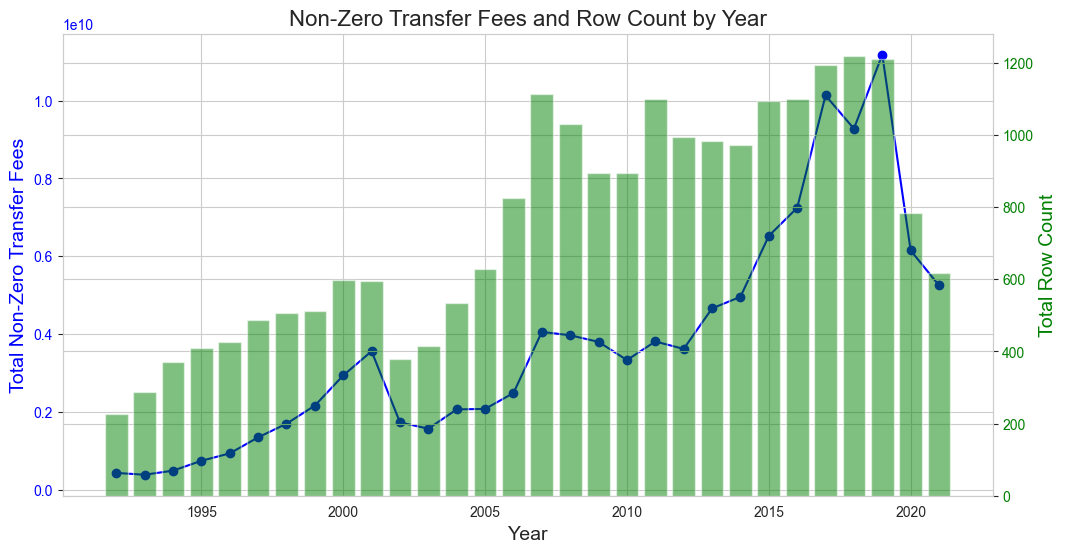

In [115]:
import matplotlib.pyplot as plt

# Filter the dataset to include only non-zero transfer fees
non_zero_transfer_fees_df = preprocessed_transfer_fees[preprocessed_transfer_fees['fee'] > 0]

# Group the data by year and calculate the total non-zero transfer fees and count of rows for each year
yearly_non_zero_fees = non_zero_transfer_fees_df.groupby('Year')['fee'].sum()
yearly_row_counts = non_zero_transfer_fees_df.groupby('Year').size()

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total non-zero transfer fees (line plot on the first subplot)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Non-Zero Transfer Fees', color='b', fontsize=14)
ax1.plot(yearly_non_zero_fees.index, yearly_non_zero_fees.values, marker='o', linestyle='-', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second subplot sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Row Count', color='g', fontsize=14)
ax2.bar(yearly_row_counts.index, yearly_row_counts.values, color='g', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='g')

# Set titles and legends
plt.title('Non-Zero Transfer Fees and Row Count by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)

# Show the combined graph
plt.show()


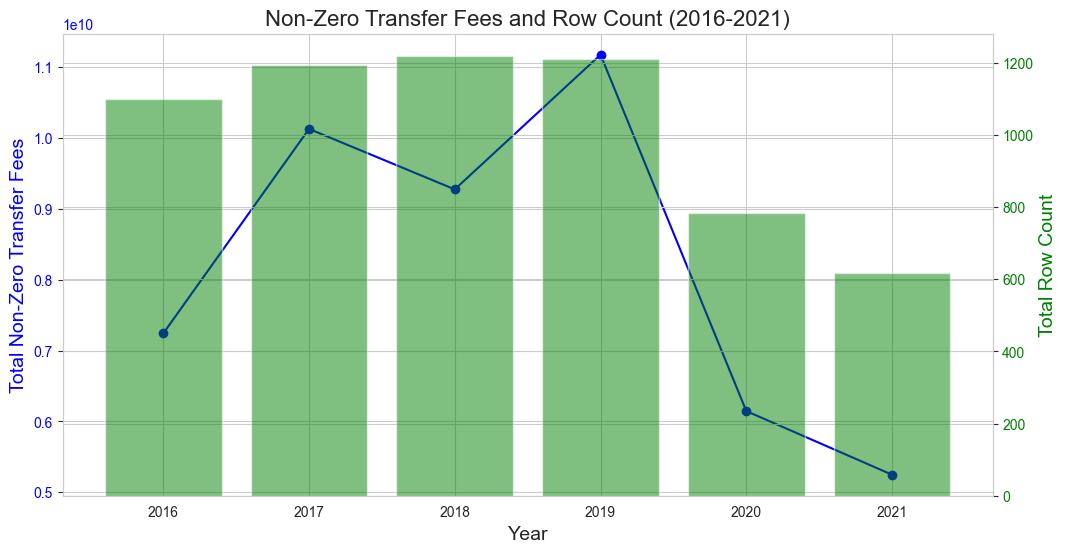

In [116]:
# Filter the dataset to include only the years 2016 to 2021
years_of_interest = range(2016, 2022)
filtered_df = preprocessed_transfer_fees[
    (preprocessed_transfer_fees['Year'] >= 2016) & (preprocessed_transfer_fees['Year'] <= 2021)
]

# Filter the dataset to include only non-zero transfer fees within the specified years
non_zero_transfer_fees_df = filtered_df[filtered_df['fee'] > 0]

# Group the data by year and calculate the total non-zero transfer fees and count of rows for each year
yearly_non_zero_fees = non_zero_transfer_fees_df.groupby('Year')['fee'].sum()
yearly_row_counts = non_zero_transfer_fees_df.groupby('Year').size()

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total non-zero transfer fees (line plot on the first subplot)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Non-Zero Transfer Fees', color='b', fontsize=14)
ax1.plot(yearly_non_zero_fees.index, yearly_non_zero_fees.values, marker='o', linestyle='-', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second subplot sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Row Count', color='g', fontsize=14)
ax2.bar(yearly_row_counts.index, yearly_row_counts.values, color='g', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='g')

# Set titles and legends
plt.title('Non-Zero Transfer Fees and Row Count (2016-2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)

# Show the combined graph
plt.show()


## Year

In [117]:
# Find the maximum year in the dataset
max_year = preprocessed_transfer_fees['Year'].max()

# Display the maximum year
max_year


2021

## Names

In [118]:
# Check for duplicate names in the dataset
duplicate_names = preprocessed_transfer_fees[preprocessed_transfer_fees.duplicated(subset='name', keep=False)]

# Display the duplicate names, if any
len(duplicate_names['name'].unique())


15308

# Join Data sets player +transfer fee


In [128]:
# Function used for normalizing names in datasets

def normalize_name(name):
    # Convert to lowercase
    name = name.lower().strip()
    # Remove special characters
    name = name.replace(".", "")
    # Remove accents
    name = unidecode(name)
    # Convert first name to initials
    split_name = name.split(" ")
    if len(split_name) > 1:
        name = split_name[0][0] + ". " + split_name[-1]
    return name

# Normalize both name columns to match
player_data['short_name'] = player_data['short_name'].apply(normalize_name)
preprocessed_transfer_fees['name'] = preprocessed_transfer_fees['name'].apply(normalize_name)


In [129]:
# Merge the player_data DataFrame with the transfer_fee_df DataFrame
merged_df = pd.merge(player_data, preprocessed_transfer_fees, how='inner', 
                     left_on=['short_name', 'year'], right_on=['name', 'Year'])

merged_df

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age_x,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,general_position,club,name,age_y,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
0,176580,https://sofifa.com/player/176580/luis-suarez/1...,l. suarez,Luis Alberto Suárez Díaz,ST,92,92,83000000.0,525000.0,29,1987-01-24,182,85,241.0,FC Barcelona,Spain Primera Division,1.0,ST,9.0,NaN,2014-07-11,2019.0,60,Uruguay,1377.0,RS,9.0,Right,4,4,5,High/Medium,Normal (170-185),Yes,NaN,"#Acrobat, #Clinical Finisher","Diver, Beat Offside Trap, Technical Dribbler (AI)",82.000000,90.000000,79.000000,87.000000,42.000000,79.00000,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,76,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37,38.741581,88+4,88+4,88+4,87+3,88+3,88+3,88+3,87+3,87+4,87+4,87+4,85+4,80+4,80+4,80+4,85+4,68+4,65+4,65+4,65+4,68+4,64+4,58+4,58+4,58+4,64+4,37+4,https://cdn.sofifa.net/players/176/580/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1377/60.png,https://cdn.sofifa.net/flags/uy.png,2017,Forward,Watford Fc,l. suarez,19.0,Colombia,Centre-Forward,CF,150000.0,Leones Fc,Colombia,0.0,in,summer,Premier League,2017,False,Not Applicable,2017,<20
1,176580,https://sofifa.com/player/176580/luis-suarez/1...,l. suarez,Luis Alberto Suárez Díaz,ST,92,92,83000000.0,525000.0,29,1987-01-24,182,85,241.0,FC Barcelona,Spain Primera Division,1.0,ST,9.0,NaN,2014-07-11,2019.0,60,Uruguay,1377.0,RS,9.0,Right,4,4,5,High/Medium,Normal (170-185),Yes,NaN,"#Acrobat, #Clinical Finisher","Diver, Beat Offside Trap, Technical Dribbler (AI)",82.000000,90.000000,79.000000,87.000000,42.000000,79.00000,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,76,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37,38.741581,88+4,88+4,88+4,87+3,88+3,88+3,88+3,87+3,87+4,87+4,87+4,85+4,80+4,80+4,80+4,85+4,68+4,65+4,65+4,65+4,68+4,64+4,58+4,58+4,58+4,64+4,37+4,https://cdn.sofifa.net/players/176/580/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1377/60.png,https://cdn.sofifa.net/flags/uy.png,2017,Forward,Watford Fc,l. suarez,19.0,Colombia,Centre-Forward,CF,150000.0,R. Valladolid B,Spain,0.0,out,summer,Premier League,2017,True,free loan,2017,<20
2,225591,https://sofifa.com/player/225591/leonardo-suar...,l. suarez,Leonardo Gabriel Suárez,CAM,71,82,2800000.0,15000.0,20,1996-03-30,167,63,483.0,Villarreal CF,Spain Primera Division,1.0,RES,29.0,NaN,2014-12-10,2018.0,52,Argentina,NaN,NaN,NaN,Left,3,3,1,Medium/Low,Lean (170-),No,NaN,NaN,"Selfish, Technical Dribbler (AI)",74.000000,65.0000

### Evaluating join 

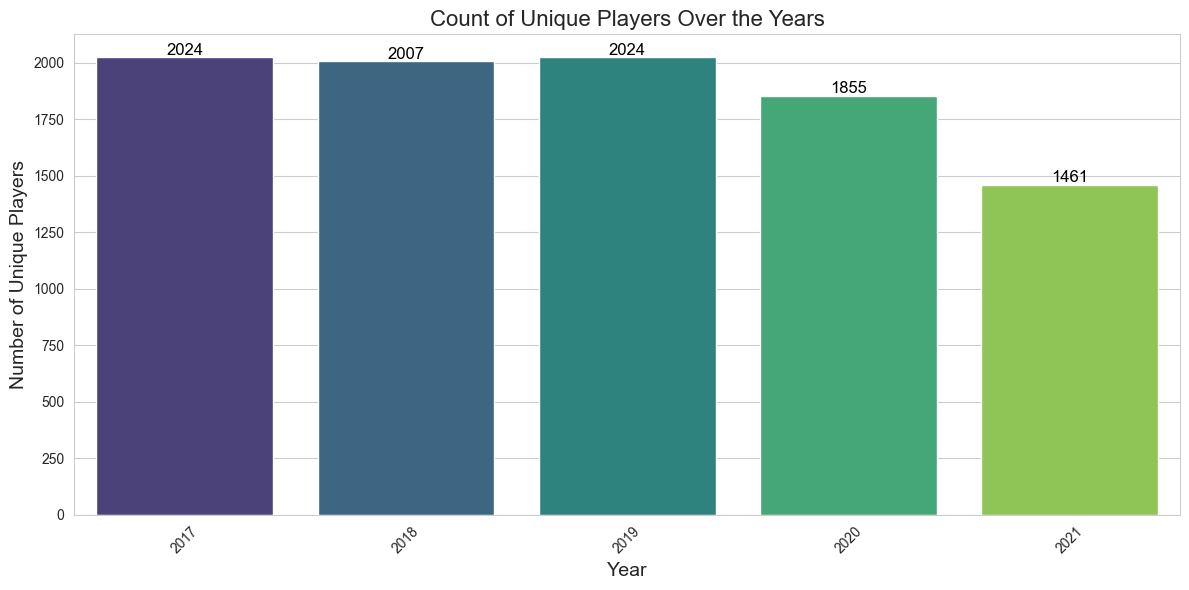

In [130]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Group the joined dataset by 'year' and count the number of unique players for each year
player_count_by_year = merged_df.groupby('year')['sofifa_id'].nunique().reset_index()
player_count_by_year.columns = ['Year', 'Number of Unique Players']

# Create a bar plot to visualize the count of unique players over the years
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Year', y='Number of Unique Players', data=player_count_by_year, palette='viridis')
plt.title('Count of Unique Players Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Unique Players', fontsize=14)
plt.xticks(rotation=45)

# Annotate the bars with the count values
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.tight_layout()
plt.show()


In [131]:
non_zero_fee_df 

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age_x,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,general_position,club,name,age_y,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
6,190871,https://sofifa.com/player/190871/neymar-da-sil...,neymar,Neymar da Silva Santos Júnior,LW,92,95,109000000.0,450000.0,24,1992-02-05,174,68,241.0,FC Barcelona,Spain Primera Division,1.0,LW,11.0,NaN,2013-07-01,2021.0,54,Brazil,1370.0,LW,10.0,Right,5,5,5,High/Medium,Unique,Yes,NaN,"#Speedster, #Dribbler, #Acrobat","Diver, Flair, Technical Dribbler (AI)",91.000000,84.000000,78.000000,95.000000,30.000000,56.00000,75,89,62,81,83,96,78,79,75,95,93,90,96,88,82,78,61,70,49,77,56,36,90,80,81,80,21,24,33,9,9,15,15,11,38.741581,84+4,84+4,84+4,89+3,88+3,88+3,88+3,89+3,88+4,88+4,88+4,87+4,78+4,78+4,78+4,87+4,63+4,58+4,58+4,58+4,63+4,58+4,46+4,46+4,46+4,58+4,20+4,https://cdn.sofifa.net/players/190/871/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1370/60.png,https://cdn.sofifa.net/flags/br.png,2017,Forward,Fc Barcelona,neymar,25.0,Brazil,Left Winger,LW,100000000.0,Paris Sg,France,222000000.0,out,summer,Laliga,2017,False,Not Applicable,2017,20-25
7,190871,https://sofifa.com/player/190871/neymar-da-sil...,neymar,Neymar da Silva Santos Júnior,LW,92,95,109000000.0,450000.0,24,1992-02-05,174,68,241.0,FC Barcelona,Spain Primera Division,1.0,LW,11.0,NaN,2013-07-01,2021.0,54,Brazil,1370.0,LW,10.0,Right,5,5,5,High/Medium,Unique,Yes,NaN,"#Speedster, #Dribbler, #Acrobat","Diver, Flair, Technical Dribbler (AI)",91.000000,84.000000,78.000000,95.000000,30.000000,56.00000,75,89,62,81,83,96,78,79,75,95,93,90,96,88,82,78,61,70,49,77,56,36,90,80,81,80,21,24,33,9,9,15,15,11,38.741581,84+4,84+4,84+4,89+3,88+3,88+3,88+3,89+3,88+4,88+4,88+4,87+4,78+4,78+4,78+4,87+4,63+4,58+4,58+4,58+4,63+4,58+4,46+4,46+4,46+4,58+4,20+4,https://cdn.sofifa.net/players/190/871/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1370/60.png,https://cdn.sofifa.net/flags/br.png,2017,Forward,Paris Saint-Germain,neymar,25.0,Brazil,Left Winger,LW,100000000.0,Fc Barcelona,Spain,222000000.0,in,summer,Ligue 1,2017,False,Not Applicable,2017,20-25
11,184344,https://sofifa.com/player/184344/leonardo-bonu...,l. bonucci,Leonardo Bonucci,CB,87,87,34000000.0,180000.0,29,1987-05-01,190,86,45.0,Juventus,Italian Serie A,1.0,CB,19.0,NaN,2010-07-01,2020.0,27,Italy,1343.0,CB,19.0,Right,3,2,3,Medium/High,Lean (185+),Yes,NaN,"#Tackling, #Tactician","Power Free-Kick, Injury Free, Leadership, Long...",70.000000,53.000000,68.0

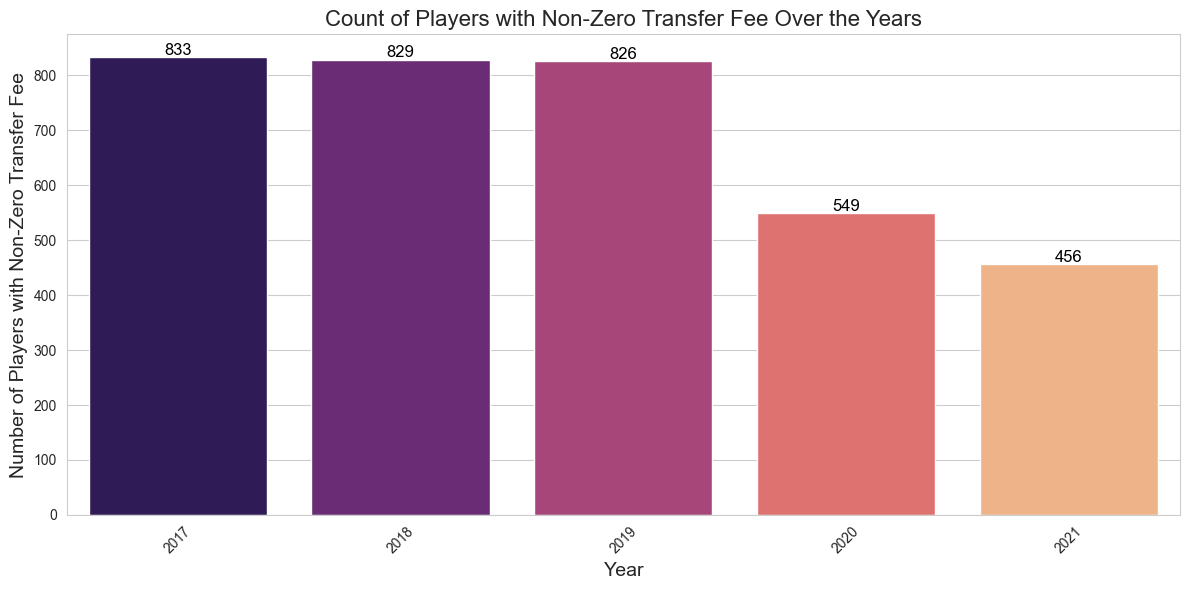

In [132]:
# Check the column names in the joined DataFrame to identify the correct column representing the year
year_columns = [col for col in merged_df.columns if 'year' in col.lower()]
non_zero_fee_df = merged_df[merged_df['fee'] > 0]


# Group the filtered dataset by the correct 'Year' column and count the number of unique players with non-zero transfer fee for each year
non_zero_fee_count_by_year = non_zero_fee_df.groupby('Year')['sofifa_id'].nunique().reset_index()
non_zero_fee_count_by_year.columns = ['Year', 'Number of Players with Non-Zero Transfer Fee']

# Create a bar plot to visualize the count of players with non-zero transfer fee over the years
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Year', y='Number of Players with Non-Zero Transfer Fee', 
                       data=non_zero_fee_count_by_year, palette='magma')
plt.title('Count of Players with Non-Zero Transfer Fee Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Players with Non-Zero Transfer Fee', fontsize=14)
plt.xticks(rotation=45)

# Annotate the bars with the count values
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.tight_layout()
plt.show()


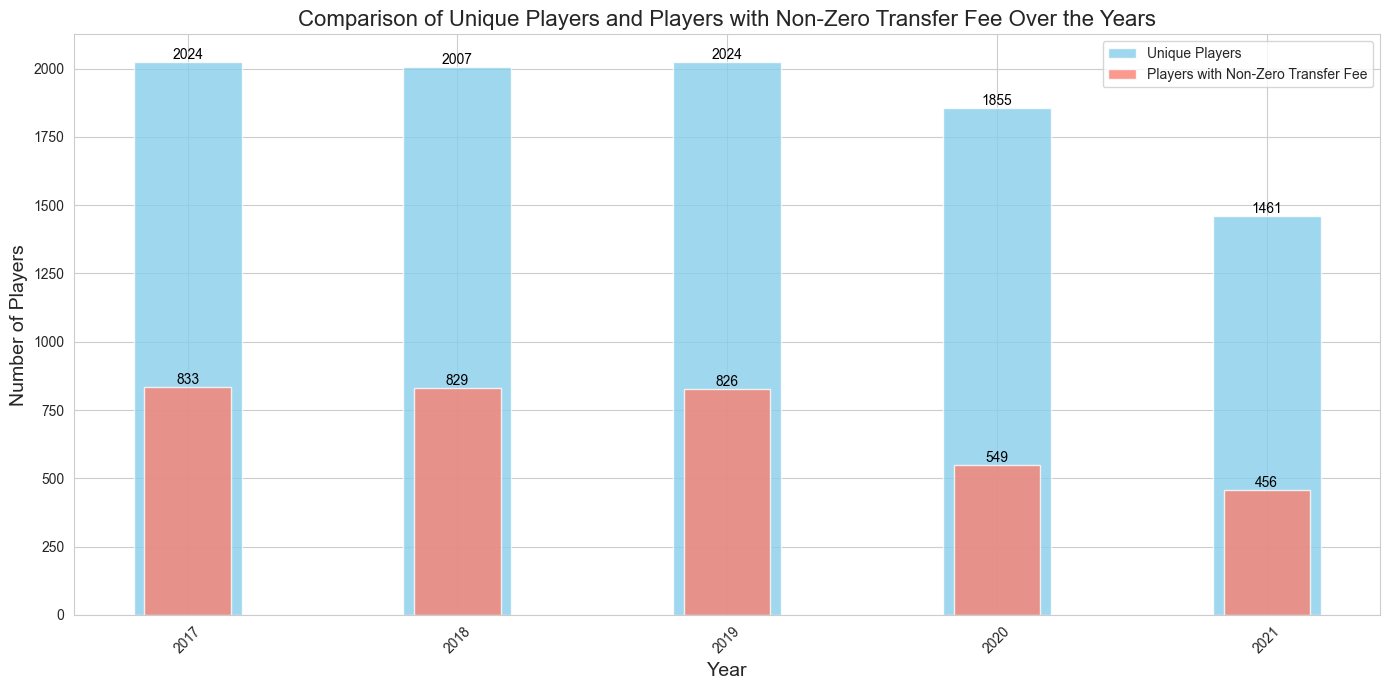

In [133]:
# Create a figure and axes for the overlaid bar plot
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Bar width for the plots
width = 0.4

# Create the first bar plot for the count of unique players over the years
bars1 = ax.bar(player_count_by_year['Year'], player_count_by_year['Number of Unique Players'], 
               width=width, align='center', alpha=0.8, color='skyblue', label='Unique Players')

# Create the second bar plot for the count of players with non-zero transfer fee over the years
bars2 = ax.bar(non_zero_fee_count_by_year['Year'], non_zero_fee_count_by_year['Number of Players with Non-Zero Transfer Fee'], 
               width=width*0.8, align='center', alpha=0.8, color='salmon', label='Players with Non-Zero Transfer Fee')

# Annotate the bars with the count values
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10, color='black')

# Set labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Players', fontsize=14)
plt.title('Comparison of Unique Players and Players with Non-Zero Transfer Fee Over the Years', fontsize=16)

# Set the x-ticks and rotation
plt.xticks(rotation=45)
ax.set_xticks(player_count_by_year['Year'])

# Add legend
plt.legend()

# Display the overlaid bar plot with 3D effect
plt.tight_layout()
plt.show()


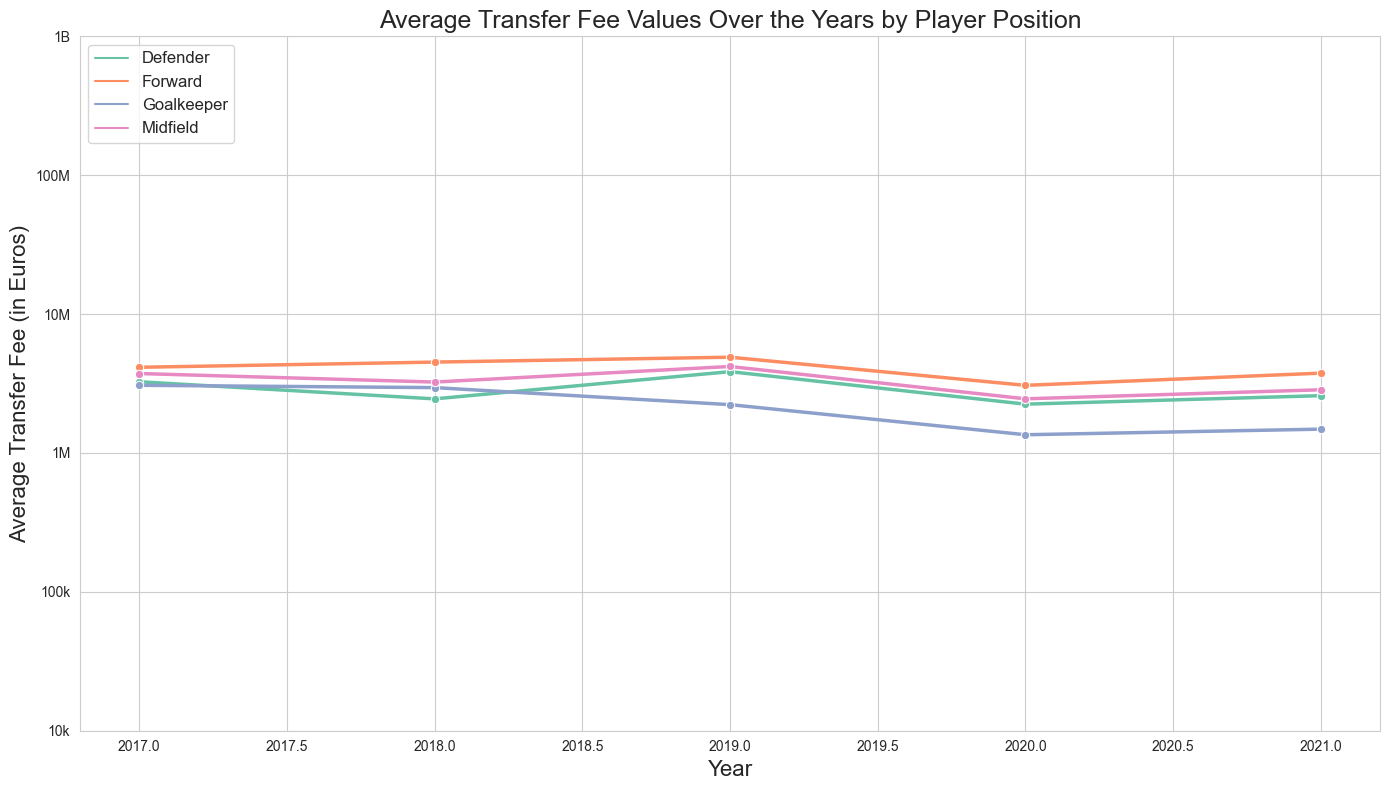

In [134]:
# Calculate the average transfer fee for each year and each general player position
average_fee_by_year_position = merged_df.groupby(['Year', 'general_position'])['fee'].mean().reset_index()

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a line plot for the average transfer fee for each player position over the years
plt.figure(figsize=(14, 8))
line_plot = sns.lineplot(x='Year', y='fee', hue='general_position', data=average_fee_by_year_position, 
                         palette='Set2', linewidth=2.5, marker='o')

# Customize the plot
plt.title('Average Transfer Fee Values Over the Years by Player Position', fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Average Transfer Fee (in Euros)', fontsize=16)
plt.yscale('log')
plt.yticks([1e4, 1e5, 1e6, 1e7, 1e8, 1e9], ['10k', '100k', '1M', '10M', '100M', '1B'])
plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


In [97]:
import plotly.graph_objects as go

# Group the merged_df by 'club' and 'dealing_club' and count the number of transfers between each pair of clubs
transfer_counts = merged_df.groupby(['club', 'dealing_club']).size().reset_index(name='count')

# Create lists of unique clubs (nodes) and transfer counts (links) for the Sankey diagram
nodes = list(set(transfer_counts['club']).union(set(transfer_counts['dealing_club'])))
node_indices = {club: i for i, club in enumerate(nodes)}
links = transfer_counts.apply(lambda row: {'source': node_indices[row['club']], 'target': node_indices[row['dealing_club']], 'value': row['count']}, axis=1).tolist()

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(node=dict(pad=15, thickness=20, line=dict(color='black', width=0.5), label=nodes),
                                 link=dict(source=[link['source'] for link in links],
                                           target=[link['target'] for link in links],
                                           value=[link['value'] for link in links]))])

# Customize the layout and title of the plot
fig.update_layout(title_text="Sankey Diagram of Player Transfers Between Clubs", font_size=10)

# Show the Sankey diagram
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Explore player features vs transfer fee

In [135]:
merged_df

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age_x,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,general_position,club,name,age_y,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,season,is_loan,loan_status,Year,age_group
0,176580,https://sofifa.com/player/176580/luis-suarez/1...,l. suarez,Luis Alberto Suárez Díaz,ST,92,92,83000000.0,525000.0,29,1987-01-24,182,85,241.0,FC Barcelona,Spain Primera Division,1.0,ST,9.0,NaN,2014-07-11,2019.0,60,Uruguay,1377.0,RS,9.0,Right,4,4,5,High/Medium,Normal (170-185),Yes,NaN,"#Acrobat, #Clinical Finisher","Diver, Beat Offside Trap, Technical Dribbler (AI)",82.000000,90.000000,79.000000,87.000000,42.000000,79.00000,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,76,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37,38.741581,88+4,88+4,88+4,87+3,88+3,88+3,88+3,87+3,87+4,87+4,87+4,85+4,80+4,80+4,80+4,85+4,68+4,65+4,65+4,65+4,68+4,64+4,58+4,58+4,58+4,64+4,37+4,https://cdn.sofifa.net/players/176/580/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1377/60.png,https://cdn.sofifa.net/flags/uy.png,2017,Forward,Watford Fc,l. suarez,19.0,Colombia,Centre-Forward,CF,150000.0,Leones Fc,Colombia,0.0,in,summer,Premier League,2017,False,Not Applicable,2017,<20
1,176580,https://sofifa.com/player/176580/luis-suarez/1...,l. suarez,Luis Alberto Suárez Díaz,ST,92,92,83000000.0,525000.0,29,1987-01-24,182,85,241.0,FC Barcelona,Spain Primera Division,1.0,ST,9.0,NaN,2014-07-11,2019.0,60,Uruguay,1377.0,RS,9.0,Right,4,4,5,High/Medium,Normal (170-185),Yes,NaN,"#Acrobat, #Clinical Finisher","Diver, Beat Offside Trap, Technical Dribbler (AI)",82.000000,90.000000,79.000000,87.000000,42.000000,79.00000,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,76,86,78,41,92,84,85,83,30,45,38,27,25,31,33,37,38.741581,88+4,88+4,88+4,87+3,88+3,88+3,88+3,87+3,87+4,87+4,87+4,85+4,80+4,80+4,80+4,85+4,68+4,65+4,65+4,65+4,68+4,64+4,58+4,58+4,58+4,64+4,37+4,https://cdn.sofifa.net/players/176/580/17_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1377/60.png,https://cdn.sofifa.net/flags/uy.png,2017,Forward,Watford Fc,l. suarez,19.0,Colombia,Centre-Forward,CF,150000.0,R. Valladolid B,Spain,0.0,out,summer,Premier League,2017,True,free loan,2017,<20
2,225591,https://sofifa.com/player/225591/leonardo-suar...,l. suarez,Leonardo Gabriel Suárez,CAM,71,82,2800000.0,15000.0,20,1996-03-30,167,63,483.0,Villarreal CF,Spain Primera Division,1.0,RES,29.0,NaN,2014-12-10,2018.0,52,Argentina,NaN,NaN,NaN,Left,3,3,1,Medium/Low,Lean (170-),No,NaN,NaN,"Selfish, Technical Dribbler (AI)",74.000000,65.0000

#### Multiple Linear Regression

In [140]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Select the features we want to explore against fee
X = merged_df[['overall', 'potential', 'age_x', 'pace', 'shooting', 'dribbling']] 
y = merged_df['fee']

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train) 

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    fee   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     179.1
Date:                Sat, 30 Sep 2023   Prob (F-statistic):          8.43e-219
Time:                        02:52:29   Log-Likelihood:            -2.0305e+05
No. Observations:               11617   AIC:                         4.061e+05
Df Residuals:                   11610   BIC:                         4.062e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.193e+07   1.86e+06    -11.791      0.0

#### Random Forest Regression

#### Gradient Boost Regression

#### Clustering

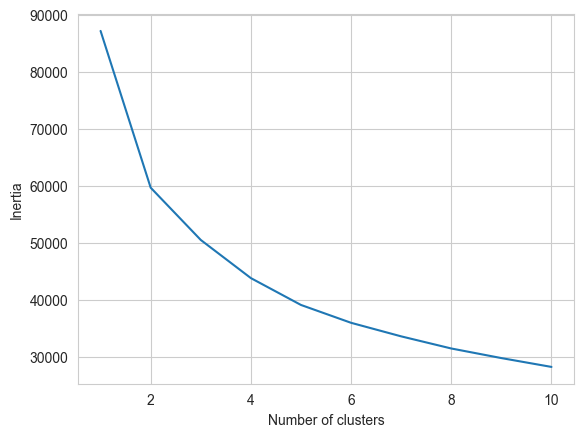

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = ['overall', 'potential', 'age_x', 'pace', 'shooting', 'dribbling']  
X = merged_df[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [142]:
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)


In [143]:
for cluster in range(optimal_clusters):
    print(f"Cluster {cluster}:")
    print(merged_df[merged_df['cluster'] == cluster][features].mean())
    print("------\n")


Cluster 0:
overall      74.875550
potential    79.193212
age_x        25.272407
pace         74.073587
shooting     64.606726
dribbling    72.982096
dtype: float64
------

Cluster 1:
overall      65.648850
potential    72.937871
age_x        23.555200
pace         64.719664
shooting     46.516405
dribbling    58.860228
dtype: float64
------

